# Week 3 - Classification

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

As shown in the cells below, using AUC as the comparison method, 
* for random-generated data sets, none of classifiers work significantly better than random guess. Although in the particular two data sets I generated, some classifiers work relatively well, it is highly case-specific. None of classifiers work well because the labels are assigned randomly, and therefore it is impossible to find any significant pattern however smart an algorithm is. 
* for andSplit-generated data sets (noise = 0.2, same for below), it is also relatively hard to tell which classifier works always better than others. The AUCs for all classifiers are about 90%. This is because it is the two classes are linearly split, so all classifiers are approaching towards a linear classification. 
* for xorSplit-generated data sets, Naives Bayes, SVM classifiers with polynomial and linear kernels, as well as logistic regression models work poorly with AUCs lower than 70%, while kNN, Decision Tree, Random Forest, Neural Netowork, and Ensemble classifiers reach an AUC level at about 90%. This is because SVM classifiers and logistic regression models attempt to find a single line to divide the dataset (number of label = 2), while we have a dataset in which labels are split oppositely along each dimension. Naive Bayes also work poorly here because it wrongly assumes independent predictors (vect1, vect2): in our xorSplit-generated datasets, the sign of vect1 is strictly associated with the sign of vect2. On the contrary, kNN attempts to find nearest neightbors and neural network (MLP) have multiple layers and non-linear activation, and therefore can distinguish data that is not linearly separable. Decision Tree, Random Forest, and Ensemble classifiers are also non-linear classifiers because these tree-like algorithms cluster the data based on nested "if-else" statements and draw vertical/horizontal lines and cluster the points in rectangles.
* for targetSplit-generated data sets, SVM classifiers with polynomial and linear kernels, as well as logistic regressions work poorly with AUCs lower than 70%, while Naives Bayes, kNN, Decision Tree, Random Forest, Neural Netowork, and Ensemble classifiers reach an AUC level at about 90%. Again, this is not a linearly seperable dataset, so SVM and logistic regression do not work. Naives Bayes works much better this time because the predictors are indepedent.
* for multiBlobs-generated data sets, all classifiers work fairly nice with over 95% AUC. It seems that it is highly case-specific in terms of which classifier works the best. Because we have five distinct classes and the data for each class cluster relatively seperatively, it does not matter how linear the classifier is. Also, because vect1 and vect2 are independent in each class, Naive Bayes also works.

Neural Network works the best for the New Group dataset, although SVM with a linear kernel and Logistic Regression model also reach similar level of high accuracy. SVM with a polynomial kernel and kNN work the worst. Random Forest works the best for the Senate Small dataset, although SVM with a linear kernel, Decision Tree, neural network and Ensemble models also work similarly well (all over 98%). Ensemble works the best for the Senate Large dataset, although like the Senate Small dataset, SVM with a linear kernel, Decision Tree, Random Forest, neural network models also work similarly well (all over 96%). Naive Bayes works the best for the Spam Email dataset, but Decision Tree, Random Forest, and Neural Network reach a similar level of accuracy at about AUC = 80%. 

In summary, Neural Network (MLP), given enough data and with less assumptions on the pattern of data, almost always works among the best. Among the other error-based Learning, SVMs with polynomial kernels work poorly probably because of overfitting—especially given that simpler models such as SVMs with linear kernels and logistic regression have already worked quite well. Compared to other approaches, Naive Bayes work the best in email data. As mentioned in the lecture, naive bayes is good not only when predictors are independent, but also when dependencies of predictors from each other are similar among predictors. It is possible that because spam emails have a similar pattern of using words like “on sale,“ “discount,” “rewards,” etc, while the patterns for newsgroups (written by people with different level of education and cultural backgrounds) and press releases (published for different events and goals) are more heterogeneous. 

#### AdaBoost (Adaptive Boosting)
* TsrgetSplit: AdaBoost works relatively well (AUC=88%) but Neural Network performs a bit better. 
* NewsGroups: AdaBoost works relatively well (AUC=83%) but Logistic Regression, Neural Network, and Neural Network perform a bit better.  


AdaBoost starts with a weak classifier, updates the weight of training instance with the misclassification rate from this trained model, and keeps sequentially adding more weak models and training them using the weighted training fata. The process continues continues until no further improvement can be made. Then it makes prediction by calculating the weighted average of the weak classifiers. Because of this adaptive process, it is highly sensitive to outliers and noisy data. Because it seems that both of our data have some influential outliers, Adaptive Boosting does not work the best. Also, the fact that AdaBoost is "best used to boost the performance of decision trees on binary classification problems" and that NewsGroups has four categories might also limit the accuracy of AdaBoost.   
https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/  
AdaBoost, however, performs much better on the targetSplit dataset than SVMs and Logistic Regressions because it does not assume a single line to cut the data. AdaBoost also outperforms the SVM with a multinomial kernel and kNN, probably because it is not as sensitive to outliers as these classifiers--weighting training instances based on error (AdaBoost) rather than distance (kNN) seems to be more appropriate in this case.

In [3]:
def try_classified(d1, d2):
    classifiers = ['Bayes', 'Linear', "Poly", 'KNN', 'Logistic Regression', 
                   'Decision Tree', "Random Forest", 'Neural Network', 'Ensemble']
    classifier_clf = [sklearn.naive_bayes.GaussianNB(), 
                      sklearn.svm.SVC(kernel = 'linear', probability = True),
                      sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True),
                      sklearn.neighbors.KNeighborsClassifier(5, weights='distance'),
                      sklearn.linear_model.LogisticRegression(),
                      sklearn.tree.DecisionTreeClassifier(),
                      sklearn.ensemble.RandomForestClassifier(),
                      sklearn.neural_network.MLPClassifier(),
                      sklearn.ensemble.GradientBoostingClassifier()]
    precision = []
    for i, name in enumerate(classifiers):
        clf = classifier_clf[i]
        clf.fit(np.stack(d1['vect'], axis=0), d1['category'])
        m = lucem_illud_2020.evaluateClassifier(clf, d2)['AUC'].mean()
        precision.append(m)
        print(name, round(m, 4))
    ind = precision.index(max(precision))
    print('Best classifier (AUC): ', classifiers[ind])

In [4]:
noise = .2

In [5]:
df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
try_classified(df1, df2)

df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
try_classified(df1, df2)

Bayes 0.471
Linear 0.4907
Poly 0.5
KNN 0.5304
Logistic Regression 0.461
Decision Tree 0.5014
Random Forest 0.4817
Neural Network 0.4877
Ensemble 0.4934
Best classifier (AUC):  KNN
Bayes 0.5265
Linear 0.5
Poly 0.5
KNN 0.4819
Logistic Regression 0.5161
Decision Tree 0.4881
Random Forest 0.501
Neural Network 0.5371
Ensemble 0.4453
Best classifier (AUC):  Neural Network


In [6]:
df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
try_classified(df1, df2)

df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
try_classified(df1, df2)

Bayes 0.9296
Linear 0.9143
Poly 0.9153
KNN 0.9096
Logistic Regression 0.9245
Decision Tree 0.8898
Random Forest 0.9188
Neural Network 0.9245
Ensemble 0.9245
Best classifier (AUC):  Bayes
Bayes 0.9174
Linear 0.9121
Poly 0.8679
KNN 0.9121
Logistic Regression 0.9121
Decision Tree 0.9268
Random Forest 0.902
Neural Network 0.9121
Ensemble 0.9086
Best classifier (AUC):  Decision Tree


In [7]:
df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise))
try_classified(df1, df2)

df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise))
try_classified(df1, df2)

Bayes 0.4743
Linear 0.5011
Poly 0.6888
KNN 0.9154
Logistic Regression 0.4819
Decision Tree 0.9254
Random Forest 0.9254
Neural Network 0.9199
Ensemble 0.9299
Best classifier (AUC):  Ensemble
Bayes 0.4049
Linear 0.5985
Poly 0.7161
KNN 0.9351
Logistic Regression 0.4207
Decision Tree 0.8957
Random Forest 0.9057
Neural Network 0.9554
Ensemble 0.9254
Best classifier (AUC):  Neural Network


In [8]:
df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
try_classified(df1, df2)

df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
try_classified(df1, df2)

Bayes 0.9135
Linear 0.5
Poly 0.5
KNN 0.8934
Logistic Regression 0.3646
Decision Tree 0.8675
Random Forest 0.8909
Neural Network 0.9081
Ensemble 0.9063
Best classifier (AUC):  Bayes
Bayes 0.9132
Linear 0.6355
Poly 0.5
KNN 0.8653
Logistic Regression 0.4191
Decision Tree 0.8398
Random Forest 0.8847
Neural Network 0.9116
Ensemble 0.8939
Best classifier (AUC):  Bayes


In [9]:
df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))
try_classified(df1, df2)

df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))
try_classified(df1, df2)

Bayes 0.9693
Linear 0.9655
Poly 0.9601
KNN 0.9641
Logistic Regression 0.9412
Decision Tree 0.9518
Random Forest 0.9594
Neural Network 0.9667
Ensemble 0.9603
Best classifier (AUC):  Bayes
Bayes 0.9879
Linear 0.9867
Poly 0.9855
KNN 0.9784
Logistic Regression 0.9762
Decision Tree 0.9772
Random Forest 0.9749
Neural Network 0.9869
Ensemble 0.9867
Best classifier (AUC):  Bayes


In [10]:
print('News Groups:')
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
try_classified(dfTrain, dfTest)

News Groups:
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Bayes 0.8356
Linear 0.9152
Poly 0.5
KNN 0.5343
Logistic Regression 0.9264
Decision Tree 0.8072
Random Forest 0.8406
Neural Network 0.9123
Ensemble 0.8732
Best classifier (AUC):  Logistic Regression


In [11]:
print('\nSenate Small:')
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
try_classified(dfTrain, dfTest)


Senate Small:
Loading senate data
Converting to vectors
Bayes 0.834
Linear 0.9793
Poly 0.5
KNN 0.8122
Logistic Regression 0.9621
Decision Tree 0.9931
Random Forest 0.9759
Neural Network 0.9468
Ensemble 0.9966
Best classifier (AUC):  Ensemble


In [12]:
print('\nSenate Large:')
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
try_classified(dfTrain, dfTest)


Senate Large:
Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors
Bayes 0.749
Linear 0.9809
Poly 0.5
KNN 0.8241
Logistic Regression 0.9537
Decision Tree 0.9943
Random Forest 0.9726
Neural Network 0.9651
Ensemble 0.9958
Best classifier (AUC):  Ensemble


In [13]:
print('\nEmail Spam:')
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())
try_classified(dfTrain, dfTest)


Email Spam:
Loading Spam
Loading Ham
Converting to vectors
Bayes 0.8162
Linear 0.7227
Poly 0.5
KNN 0.7333
Logistic Regression 0.611
Decision Tree 0.7484
Random Forest 0.7423
Neural Network 0.8127
Ensemble 0.5972
Best classifier (AUC):  Bayes


In [14]:
df1, df2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
try_classified(df1, df2)
clf = sklearn.ensemble.AdaBoostClassifier()
clf.fit(np.stack(df1['vect'], axis=0), df1['category'])
print("AdaBoost", round(lucem_illud_2020.evaluateClassifier(clf, df2)['AUC'].mean(), 4))

Bayes 0.8955
Linear 0.6035
Poly 0.5
KNN 0.9053
Logistic Regression 0.4954
Decision Tree 0.9103
Random Forest 0.9054
Neural Network 0.8957
Ensemble 0.9006
Best classifier (AUC):  Decision Tree
AdaBoost 0.9055


In [57]:
d1, d2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
try_classified(d1, d2)
clf = sklearn.ensemble.AdaBoostClassifier()
clf.fit(np.stack(d1['vect'], axis=0), d1['category'])
print("AdaBoost", round(lucem_illud_2020.evaluateClassifier(clf, d2)['AUC'].mean(), 4))

Bayes 0.8544
Linear 0.9226
Poly 0.5
KNN 0.5643
Logistic Regression 0.9256
Decision Tree 0.8254
Random Forest 0.85
Neural Network 0.9137
Ensemble 0.8846
Best classifier (AUC):  Logistic Regression
AdaBoost 0.8167


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


For this week of homework I am using a small dataset "train.csv." This is a [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) dataset for predicting whether a tweet is related to a real disaster. Here I only used the train dataset but divided it into training, testing and extrapolation (uncoded) data. For each text, it should be either about a disaster, or not.  
Logistic regression with penalty has an accuracy of about 87% on both train and test sets, which is slightly higher than that for Naive Bayes, which is about 84% on both train and test sets.

In [17]:
demos_text = pandas.read_csv('train.csv')
demos_text['category']=demos_text['target']
demos_text['category'] = [r == 1 for r in demos_text['category']]
demos_text = demos_text[['text', 'category']]
demos_text.shape

(7613, 2)

In [18]:
demos_text = lucem_illud_2020.generateVecs(demos_text)

In [19]:
train_demos, test_demos = lucem_illud_2020.trainTestSplit(demos_text, holdBackFraction=.2)
train_demos, uncoded = lucem_illud_2020.trainTestSplit(demos_text, holdBackFraction=.2)
train_demos.shape, test_demos.shape, uncoded.shape

((6091, 5), (1522, 5), (1522, 5))

In [43]:
uncoded = uncoded[['text', 'vect']] ## pretend it is uncoded data

#### Logistic Regression

In [20]:
pca = sklearn.decomposition.PCA()
reduced = pca.fit_transform(np.stack(train_demos['vect'], axis=0))
train_demos['pca'] = [r for r in reduced]
train_demos['pca_reduced_10'] = train_demos['pca'].apply(lambda x: x[:10])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_demos['pca_reduced_10'], axis=0), train_demos['category'])
logistic.score(np.stack(train_demos['pca_reduced_10'], axis=0), train_demos['category'])

0.6593334427844361

In [21]:
reduced_data_test = pca.transform(np.stack(test_demos['vect'], axis=0))
test_demos['pca'] = [r for r in reduced_data_test]
test_demos['pca_reduced_10'] = test_demos['pca'].apply(lambda x: x[:10])
logistic.score(np.stack(test_demos['pca_reduced_10'], axis=0), test_demos['category'])

0.657030223390276

In [22]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_demos['vect'], axis=0), train_demos['category'])
print(logistic_l1.score(np.stack(train_demos['vect'], axis=0), train_demos['category']))
print(logistic_l1.score(np.stack(test_demos['vect'], axis=0), test_demos['category']))

0.8732556230504023
0.8587385019710907


In [23]:
lucem_illud_2020.evaluateClassifier(logistic_l1, train_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.126744,0.861473,0.846889,0.832451,0.948251
True,0.126744,0.861473,0.919297,0.809532,0.774696


In [24]:
lucem_illud_2020.evaluateClassifier(logistic_l1, test_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.141261,0.84869,0.835962,0.816973,0.930913
True,0.141261,0.84869,0.896673,0.789767,0.766467


0.7664670658682635
0.8966725043782837
0.8264729620661825


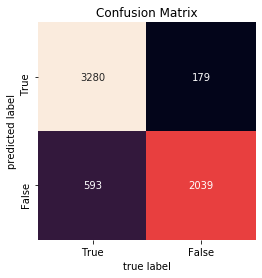

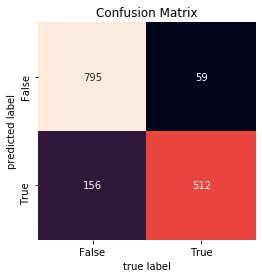

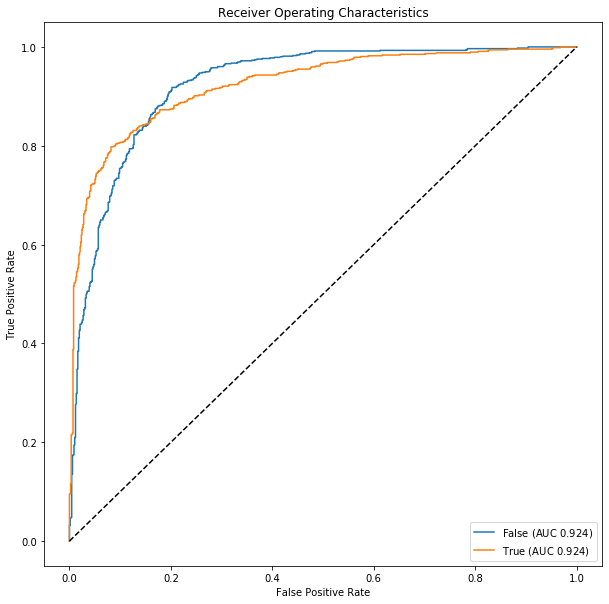

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


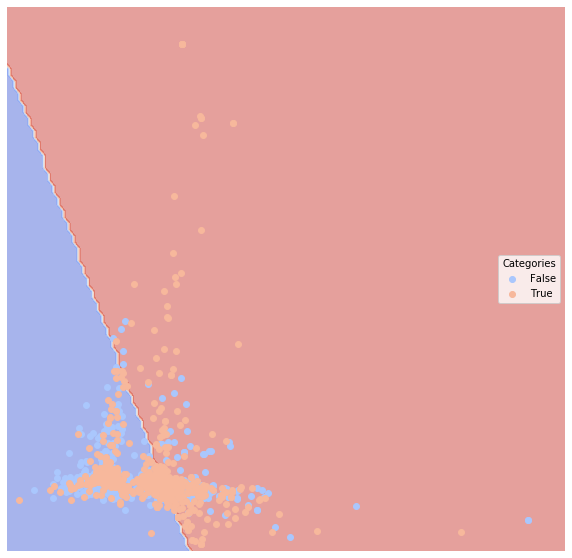

In [25]:
test_demos['log_predict'] = logistic_l1.predict(np.stack(test_demos['vect'], axis=0))
print(sklearn.metrics.precision_score(test_demos['log_predict'], test_demos['category']))
print(sklearn.metrics.recall_score(test_demos['log_predict'], test_demos['category']))
print(sklearn.metrics.f1_score(test_demos['log_predict'], test_demos['category']))
lucem_illud_2020.plotConfusionMatrix(logistic_l1, train_demos)
lucem_illud_2020.plotConfusionMatrix(logistic_l1, test_demos)
lucem_illud_2020.plotMultiROC(logistic_l1, test_demos)
lucem_illud_2020.plotregions(logistic_l1, test_demos)

In [44]:
#code uncoded data
uncoded['log_prediction'] = logistic_l1.predict(np.stack(uncoded['vect'], axis=0))
uncoded.head()

,text,vect,log_prediction
3744,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
889,I'm over here listening to Bloody Jay. ???? h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
3927,85V-265V 10W LED Warm White Light Motion Senso...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
5542,Who Else Wants Documents Radiation Emergency P...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
4998,Listen LIve: http://t.co/1puLaekxcq #Author #I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False


#### Naive Bayes

In [26]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_demos['vect'], axis=0), train_demos['category'])
print(naiveBayes.score(np.stack(train_demos['vect'], axis=0), train_demos['category']))
print(naiveBayes.score(np.stack(test_demos['vect'], axis=0), test_demos['category']))

0.8596289607617796
0.8528252299605782


In [27]:
lucem_illud_2020.evaluateClassifier(naiveBayes, train_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.140371,0.846524,0.832143,0.817093,0.943047
True,0.140371,0.846524,0.909258,0.789972,0.750000


In [28]:
lucem_illud_2020.evaluateClassifier(naiveBayes, test_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.147175,0.840976,0.824074,0.807754,0.937939
True,0.147175,0.840976,0.903636,0.784668,0.744012


0.7440119760479041
0.9036363636363637
0.8160919540229885


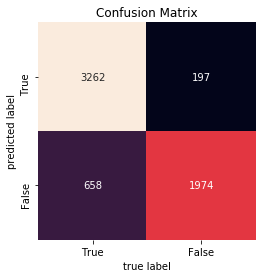

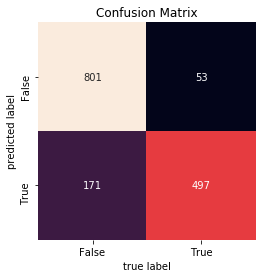

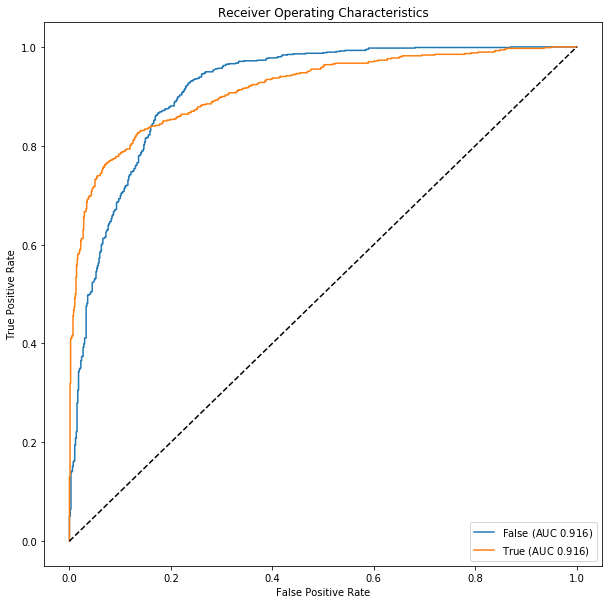

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


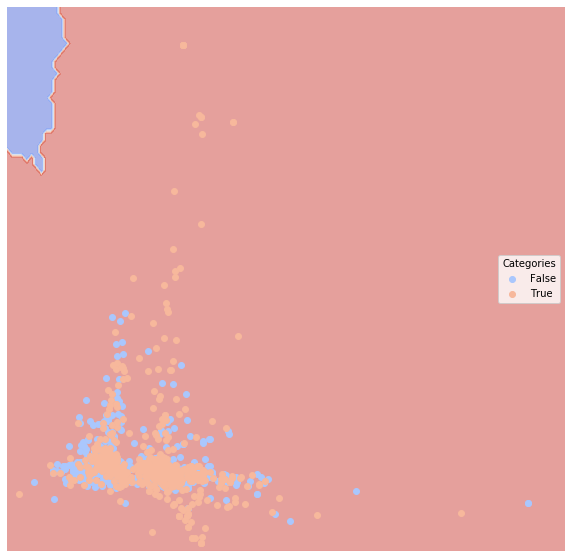

In [30]:
test_demos['nb_predict'] = naiveBayes.predict(np.stack(test_demos['vect'], axis=0))
print(sklearn.metrics.precision_score(test_demos['nb_predict'], test_demos['category']))
print(sklearn.metrics.recall_score(test_demos['nb_predict'], test_demos['category']))
print(sklearn.metrics.f1_score(test_demos['nb_predict'], test_demos['category']))
lucem_illud_2020.plotConfusionMatrix(naiveBayes, train_demos)
lucem_illud_2020.plotConfusionMatrix(naiveBayes, test_demos)
lucem_illud_2020.plotMultiROC(naiveBayes, test_demos)
lucem_illud_2020.plotregions(naiveBayes, test_demos)

In [45]:
#code uncoded data
uncoded['ng_prediction'] = naiveBayes.predict(np.stack(uncoded['vect'], axis=0))
uncoded.head()

,text,vect,log_prediction,ng_prediction
3744,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False
889,I'm over here listening to Bloody Jay. ???? h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False
3927,85V-265V 10W LED Warm White Light Motion Senso...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False
5542,Who Else Wants Documents Radiation Emergency P...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,True
4998,Listen LIve: http://t.co/1puLaekxcq #Author #I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

   It turns out the decision tree classification works not quite well, with an accuracy of less than 70% on both datasets. It also seems that with higher max_depth the accuracy can be improved to about 80%. With an ensemble classifier which baggs trees into a random forest, the accuracy for both datasets is slightly increased to about 74%.  
   Generally speaking, ensemble methods repeatedly selects a random sample with replacement of the training set (bagging) and fits decision trees to these samples, and makes prediction by taking the majority vote. It helps correct decison tree's overfitting problem. However, as shown in the confusion matrix below, both types of errors are significant. 

#### Decision tree

In [31]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_demos['vect'], axis =0), train_demos['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [32]:
lucem_illud_2020.evaluateClassifier(clf_tree, train_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.32704,0.656281,0.686974,0.660671,0.779127
True,0.32704,0.656281,0.647601,0.547062,0.533435


In [33]:
lucem_illud_2020.evaluateClassifier(clf_tree, test_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.300263,0.684833,0.702345,0.675056,0.806792
True,0.300263,0.684833,0.695009,0.583056,0.562874


0.7200903412180584
0.6997371879106439
0.7051172493676835


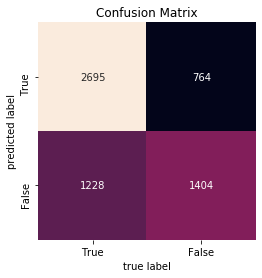

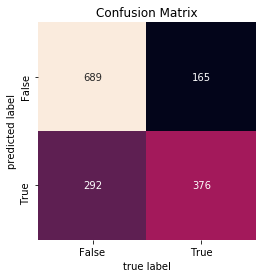

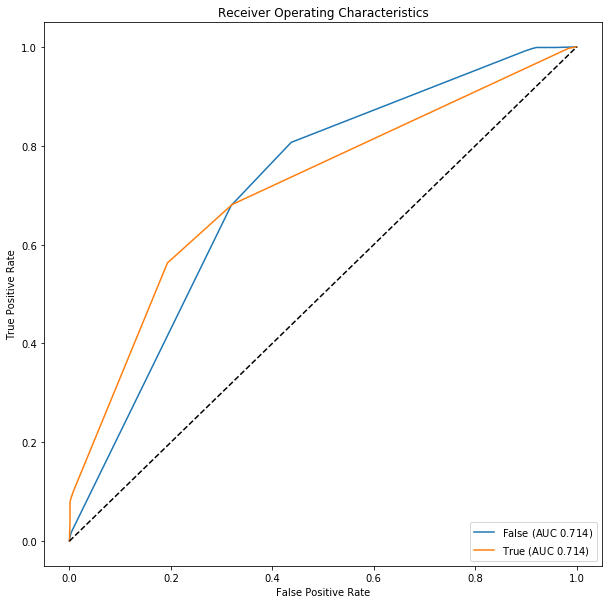

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


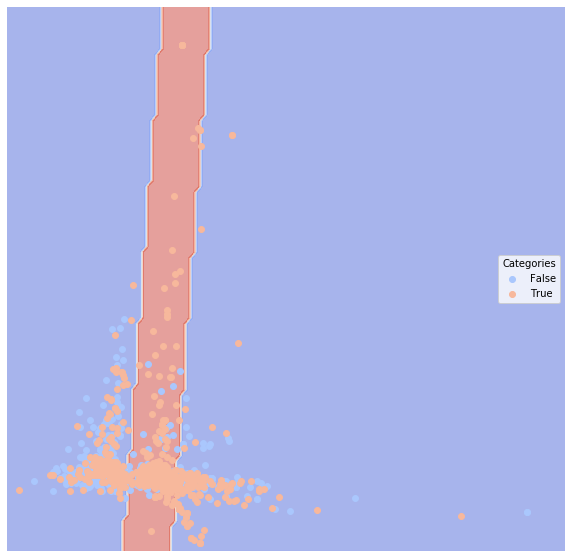

In [34]:
test_demos['dt_predict'] = clf_tree.predict(np.stack(test_demos['vect'], axis=0))
print(sklearn.metrics.precision_score(test_demos['dt_predict'], test_demos['category'],
                                      average = 'weighted'))
print(sklearn.metrics.recall_score(test_demos['dt_predict'], test_demos['category'],
                                  average = 'weighted'))
print(sklearn.metrics.f1_score(test_demos['dt_predict'], test_demos['category'],
                               average = 'weighted'))
lucem_illud_2020.plotConfusionMatrix(clf_tree, train_demos)
lucem_illud_2020.plotConfusionMatrix(clf_tree, test_demos)
lucem_illud_2020.plotMultiROC(clf_tree, test_demos)
lucem_illud_2020.plotregions(clf_tree, test_demos)

In [60]:
print(sklearn.metrics.accuracy_score(train_demos['category'], 
                            clf_tree.predict(np.stack(train_demos['vect'], axis = 0))))
print(sklearn.metrics.accuracy_score(test_demos['category'], 
                            clf_tree.predict(np.stack(test_demos['vect'], axis = 0))))

0.6729601050730586
0.6997371879106439


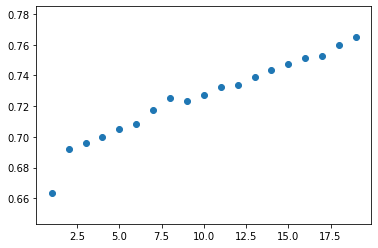

In [35]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_demos['vect'], axis =0), train_demos['category'])
    score = sklearn.metrics.accuracy_score(test_demos['category'], 
                                    tree2.predict(np.stack(test_demos['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [46]:
#code uncoded data
uncoded['dt_prediction'] = clf_tree.predict(np.stack(uncoded['vect'], axis=0))
uncoded.head()

,text,vect,log_prediction,ng_prediction,dt_prediction
3744,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False
889,I'm over here listening to Bloody Jay. ???? h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False
3927,85V-265V 10W LED Warm White Light Motion Senso...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False
5542,Who Else Wants Documents Radiation Emergency P...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,True,True
4998,Listen LIve: http://t.co/1puLaekxcq #Author #I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,True


In [36]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) 
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, 
                                         max_samples=0.8, random_state=1) 
bag.fit(np.stack(train_demos['vect'], axis =0), train_demos['category']) 

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
      

In [47]:
#code uncoded data
uncoded['bag_prediction'] = bag.predict(np.stack(uncoded['vect'], axis=0))
uncoded.head()

,text,vect,log_prediction,ng_prediction,dt_prediction,bag_prediction
3744,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False
889,I'm over here listening to Bloody Jay. ???? h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False
3927,85V-265V 10W LED Warm White Light Motion Senso...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False
5542,Who Else Wants Documents Radiation Emergency P...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,True,True,False
4998,Listen LIve: http://t.co/1puLaekxcq #Author #I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,True,True


0.7678339032312759
0.7503285151116952
0.754452925294082


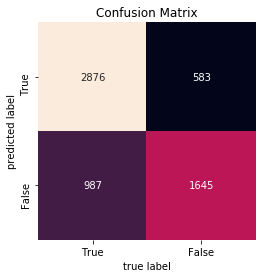

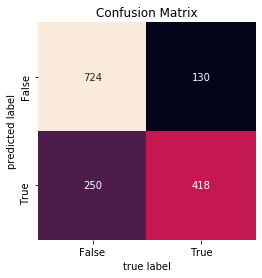

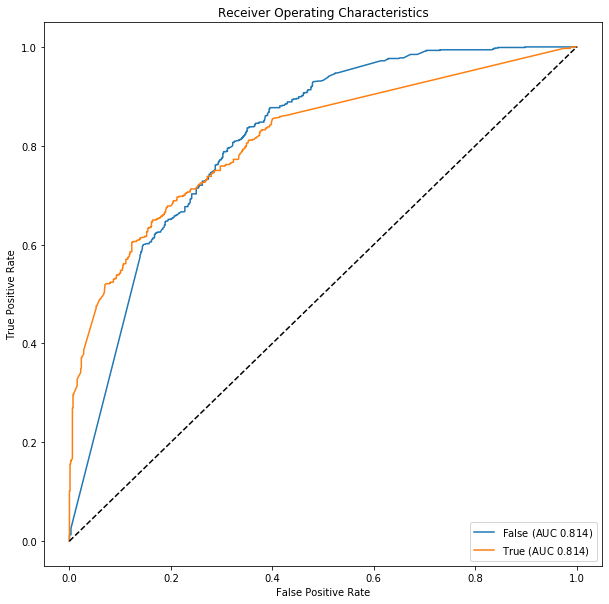

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


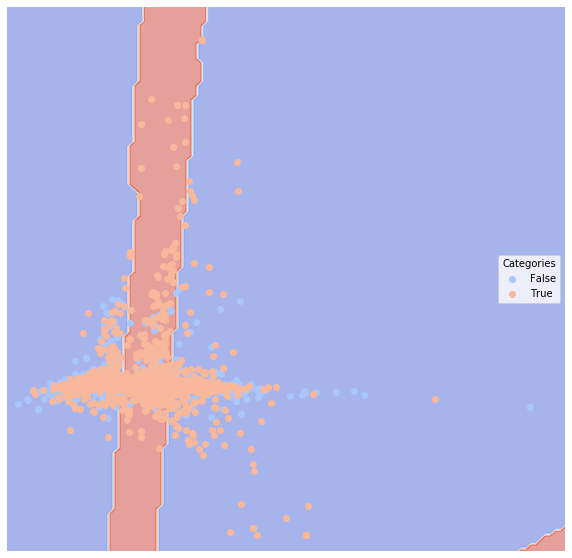

In [37]:
test_demos['bag_predict'] = bag.predict(np.stack(test_demos['vect'], axis=0))
print(sklearn.metrics.precision_score(test_demos['bag_predict'], test_demos['category'],
                                      average = 'weighted'))
print(sklearn.metrics.recall_score(test_demos['bag_predict'], test_demos['category'],
                                  average = 'weighted'))
print(sklearn.metrics.f1_score(test_demos['bag_predict'], test_demos['category'],
                               average = 'weighted'))
lucem_illud_2020.plotConfusionMatrix(bag, train_demos)
lucem_illud_2020.plotConfusionMatrix(bag, test_demos)
lucem_illud_2020.plotMultiROC(bag, test_demos)
lucem_illud_2020.plotregions(bag, train_demos)

In [39]:
lucem_illud_2020.evaluateClassifier(bag, train_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.257757,0.728227,0.744499,0.714732,0.831454
True,0.257757,0.728227,0.738330,0.623499,0.625000


In [40]:
lucem_illud_2020.evaluateClassifier(bag, test_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.249671,0.736762,0.743326,0.715588,0.847775
True,0.249671,0.736762,0.762774,0.641562,0.625749


In [61]:
print(sklearn.metrics.accuracy_score(train_demos['category'], 
                            bag.predict(np.stack(train_demos['vect'], axis = 0))))
print(sklearn.metrics.accuracy_score(test_demos['category'], 
                            bag.predict(np.stack(test_demos['vect'], axis = 0))))

0.7422426530947299
0.7503285151116952


## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

k-means is unsupervised and is used for clustering etc and kNN is supervised. K-means partitions a set of points into k clusters such that the distances among points in each cluster are minimized. kNN is a classification algorithm to determine the classification of points based on its k nearest points. It is supervised because we classify points based on the known classification of other points.  
https://stats.stackexchange.com/questions/56500/what-are-the-main-differences-between-k-means-and-k-nearest-neighbours  
The performance of kNN does not perform quite well either. The accuracy on the train set is 64%, and the accuracy on the test set is 62%. While kNN amazingly reduces the false positive error, the false positive error becomes more significant--it fails to detect the tweets that are reporting real disasters.

In [41]:
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 15, 
                                                      weights="uniform")
clf_knearest.fit(np.stack(train_demos['vect'], axis = 0), train_demos['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [63]:
print(sklearn.metrics.accuracy_score(train_demos['category'], 
                            clf_knearest.predict(np.stack(train_demos['vect'], axis = 0))))
print(sklearn.metrics.accuracy_score(test_demos['category'], test_demos['knn_predict']))

0.6351994746347069
0.6241787122207622


0.9396376321083701
0.6241787122207622
0.7155341625171976


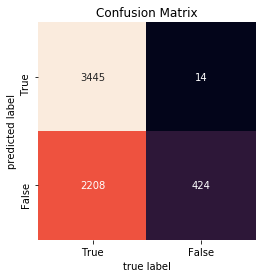

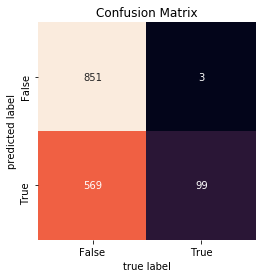

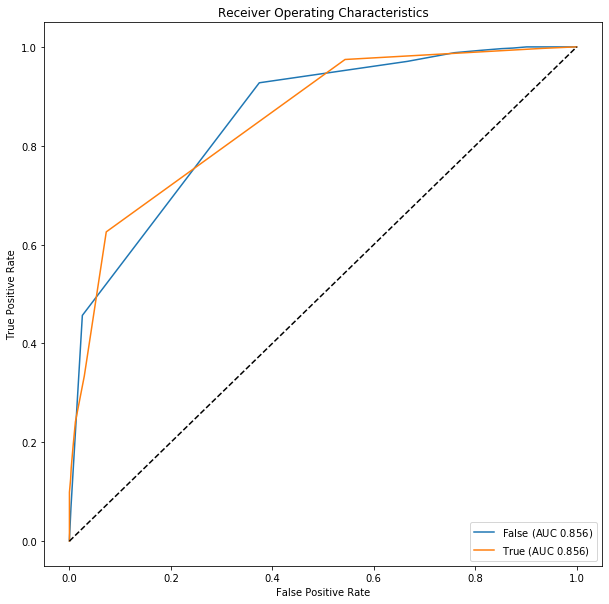

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


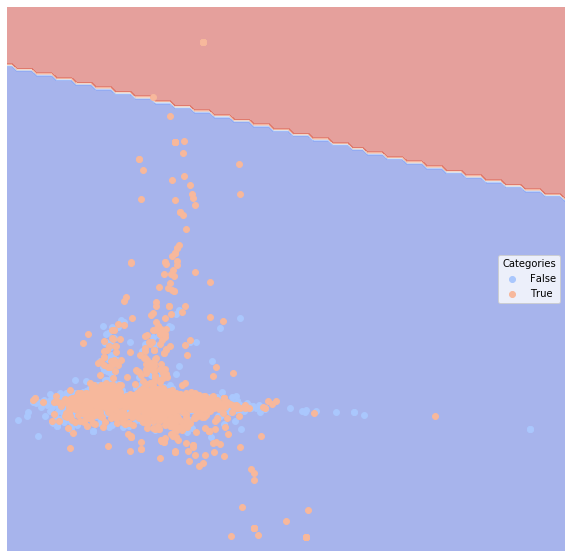

In [48]:
test_demos['knn_predict'] = clf_knearest.predict(np.stack(test_demos['vect'], axis=0))
print(sklearn.metrics.precision_score(test_demos['knn_predict'], test_demos['category'],
                                      average = 'weighted'))
print(sklearn.metrics.recall_score(test_demos['knn_predict'], test_demos['category'],
                                  average = 'weighted'))
print(sklearn.metrics.f1_score(test_demos['knn_predict'], test_demos['category'],
                               average = 'weighted'))
lucem_illud_2020.plotConfusionMatrix(clf_knearest, train_demos)
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_demos)
lucem_illud_2020.plotMultiROC(clf_knearest, test_demos)
lucem_illud_2020.plotregions(clf_knearest, train_demos)

In [49]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.364801,0.578523,0.609411,0.609243,0.995953
True,0.364801,0.578523,0.968037,0.518447,0.161094


In [50]:
lucem_illud_2020.evaluateClassifier(clf_knearest, test_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.375821,0.572345,0.599296,0.599162,0.996487
True,0.375821,0.572345,0.970588,0.517695,0.148204


In [51]:
#code uncoded data
uncoded['knn_prediction'] = clf_knearest.predict(np.stack(uncoded['vect'], axis=0))
uncoded.head()

,text,vect,log_prediction,ng_prediction,dt_prediction,bag_prediction,knn_prediction
3744,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False,False
889,I'm over here listening to Bloody Jay. ???? h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False,False
3927,85V-265V 10W LED Warm White Light Motion Senso...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False,False
5542,Who Else Wants Documents Radiation Emergency P...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,True,True,False,False
4998,Listen LIve: http://t.co/1puLaekxcq #Author #I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,True,True,False


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

The neutral network works amazingly well with 98% accuracy on the train set and about 93% accuracy on the test set. A multiplayer perception is composed of an input layer to receive the signal, an output layer that makes a decision about the input, and multiple hidden layers in between. A multiplayer perception trains and models the correlation between a set of input-output pairs and then adjusts the weights of the models to minimize error. Therefore, unlike logistic regression and Naive Bayes, it does not assume posterior distributions and probability about the pattern of the data. Compared to kNN and decision tree approaches, it is less sensitive to outliers and noices with its repetitive, feedforward, training process.  
https://pathmind.com/wiki/multilayer-perceptron

In [52]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_demos['vect'], axis=0), train_demos['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [64]:
print(sklearn.metrics.accuracy_score(train_demos['category'], 
                            clf_nn.predict(np.stack(train_demos['vect'], axis = 0))))
print(sklearn.metrics.accuracy_score(test_demos['category'], test_demos['nn_predict']))

0.9839106879001805
0.9316688567674113


0.9318479969897994
0.9316688567674113
0.9315611785454854


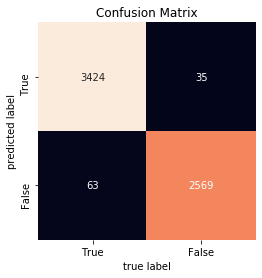

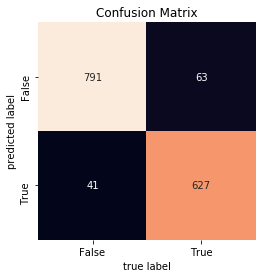

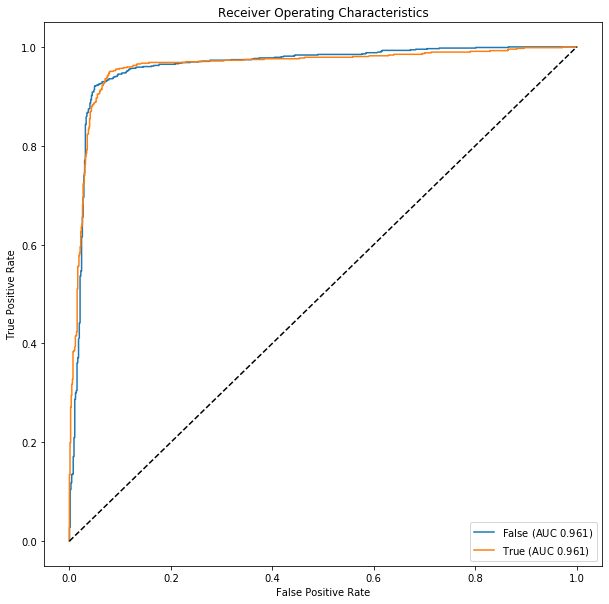

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


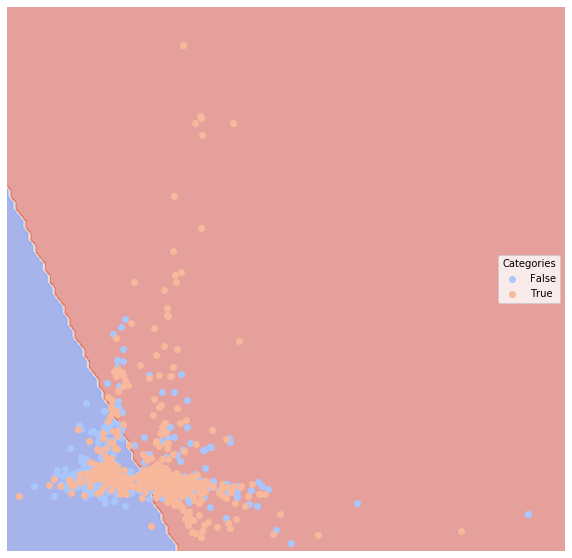

In [53]:
test_demos['nn_predict'] = clf_nn.predict(np.stack(test_demos['vect'], axis=0))
print(sklearn.metrics.precision_score(test_demos['nn_predict'], test_demos['category'],
                                      average = 'weighted'))
print(sklearn.metrics.recall_score(test_demos['nn_predict'], test_demos['category'],
                                  average = 'weighted'))
print(sklearn.metrics.f1_score(test_demos['nn_predict'], test_demos['category'],
                               average = 'weighted'))
lucem_illud_2020.plotConfusionMatrix(clf_nn, train_demos)
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_demos)
lucem_illud_2020.plotMultiROC(clf_nn, test_demos)
#lucem_illud_2020.plotregions(clf_nn, train_demos)
lucem_illud_2020.plotregions(clf_nn, test_demos)

In [54]:
lucem_illud_2020.evaluateClassifier(clf_nn, train_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.016089,0.982973,0.981933,0.977743,0.989881
True,0.016089,0.982973,0.986559,0.973288,0.976064


In [55]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_demos)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.068331,0.932426,0.950721,0.921979,0.926230
True,0.068331,0.932426,0.908696,0.879861,0.938623


In [56]:
#code uncoded data
uncoded['nn_prediction'] = clf_nn.predict(np.stack(uncoded['vect'], axis=0))
uncoded.head()

,text,vect,log_prediction,ng_prediction,dt_prediction,bag_prediction,knn_prediction,nn_prediction
3744,http://t.co/iNkuv5DNTX #auction #shoes Retro 5...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False,False,True
889,I'm over here listening to Bloody Jay. ???? h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False,False,False
3927,85V-265V 10W LED Warm White Light Motion Senso...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,False,False,False,True
5542,Who Else Wants Documents Radiation Emergency P...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,True,True,False,False,True
4998,Listen LIve: http://t.co/1puLaekxcq #Author #I...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,False,True,True,False,False
